# **Representational similarity analysis: a tutorial with rsatoolbox**
written for [Diedrichsen Lab](https://www.diedrichsenlab.org) and [Brain and Mind Institute](https://www.uwo.ca/bmi/)

This tutorial will walk you through the basic concept to understand representational similarity analysis (RSA) and how to apply it using the rsatoolbox. [Click here](https://rsatoolbox.readthedocs.io/en/stable/) for more documentation about the rsatoolbox. To find out more about how RSA works and to learn how to use the PcmPy toolbox to perform RSA, you can check [this tutorial](https://github.com/mnlmrc/didactic/blob/main/rsa_pcmpy.ipynb).

In [1]:
import pickle
import pandas as pd
import rsatoolbox as rsa
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Example dataset
--
Throughout the tutorial, we use example fMRI data from an experiment in which participants responded to tactile stimuli on either the index or ring finger, following a visual cue that indicated the probability of stimulation for each finger. The visual cues were 0%-100% ring-index, 25%-75%, 50%-50%, 75%-25% or 100%-0%. To simplify, we will use condition labels only reporting the index probability, i.e., 0%, 25%, 50%, 75%, 100%. The data were collected in ten blocks. In the first-level GLM, we modelled neural activation $y_i$ in the $ i^{th} $ voxel as a linear combination of 5 regressors of interests, each corresponding to a probability cue:

$$ y_i = X \beta_i + \epsilon $$

The $\beta$ coefficients from each regressor indicate how much each voxel was activated for each probability cue. The goal of RSA is to understand whether voxels show different **activity patterns** between conditions, regardless of the overall amount of activation. Let's first load the data:

In [2]:
f = open('data_demo_smp.p', 'rb')
Y, ResMS, residuals, cond_vec, part_vec, cond_names = pickle.load(f)

To use the rsatoolbox, we first need to organize or data in a Dataset object. We want to compute the cross-validated [Mahalanobis distance](https://github.com/mnlmrc/didactic/blob/main/rsa_pcmpy.ipynb#Prewhitening-and-Mahalanobis-distance) between pairs of conditions, so before creating the dataset, we will prewhiten our data using the ResMS from the first-level GLM (i.e., univariate prewhitening). The `obs_descriptors` dictionary should contain the field `'conds'` corresponding to a vector of condition labels and the field `'run'` with partition labels (e.g., fMRI runs) to perform cross-validation.

In [3]:
Y_prewhitened = Y / np.sqrt(ResMS)

# map cond_vec to meaningful values before including it in the dataset. It will be handy for visualization
cond_vec_map = {
    0: '0%',
    1: '25%',
    2: '50%',
    3: '75%',
    4: '100%'
}
cond_vec = pd.Series(cond_vec).map(cond_vec_map)

dataset = rsa.data.Dataset(
        Y_prewhitened,
        channel_descriptors={
            'channel': np.array(['vox_' + str(x) for x in range(Y_prewhitened.shape[-1])])},
        obs_descriptors={'conds': cond_vec,
                         'run': part_vec},
    )

We can now use the function `calc_rdm` to compute the distances:

In [4]:
rdm = rsa.rdm.calc_rdm(dataset, method='crossnobis', descriptor='conds', cv_descriptor='run')

# conditions in the rdm object are in alphabetic order, i.e, 0%, 100%, 25%, 50%, 75%. Let's reorder them for better visualization
rdm.reorder([0, 2, 3, 4, 1])

The variable `rdm` contains a representation dissimilarity matrix, i.e., a matrix of squared cross-validated distances between conditions. For more information about RDMs objects and how to manipulate them, see [this documentation](https://rsatoolbox.readthedocs.io/en/stable/operations.html). Representation dissimilarity matrices stored in RDMs object can be directly plotted using the vis package in rsatoolbox:

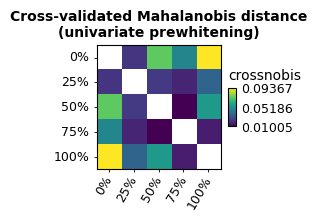

In [5]:
fig, ax, _ = rsa.vis.show_rdm(rdm, cmap='viridis', rdm_descriptor='Cross-validated Mahalanobis distance\n(univariate prewhitening)', pattern_descriptor='conds', show_colorbar='panel')
plt.show()